In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image, ImageDraw, ImageFont

In [3]:
## First, I'll compute the camera calibration using chessboard images
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

In [4]:
#define the undistortion function based on the objpoints and imgpoints
def undist(img,objpoints,imgpoints):
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    undist = cv2.undistort(img,mtx,dist,None,mtx)
    return undist

In [5]:
#function to filter the gradient on any or both axises
def mag_thresh(img, sobel_kernel=3,sobel_axis='xy', mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    if sobel_axis != 'xy':
        if sobel_axis == 'x':
            sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        elif sobel_axis == 'y':
            sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 1, ksize=sobel_kernel)
    # Calculate the absolute value of sobelx
    abs_sobel = np.absolute(sobel)
    # Rescale to 8 bit
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(abs_sobel >= mag_thresh[0]) & (abs_sobel <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

In [6]:
#define the hls channel s threshold function
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    img_hls = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    s = np.array(img_hls[:,:,2])
    # 3) Return a binary image of threshold result
    binary_output = np.zeros_like(s)
    binary_output [(s>thresh[0])&(s<=thresh[1])] = 1 # placeholder line
    return binary_output

In [7]:
# four source points
src = np.float32(
[[261,696],
 [583,459],
 [703,459],
 [1062,696]])
    
    # four desired points
dst = np.float32(
[[320,720],
 [320,0],
 [960,0],
 [960,720]])
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst,src)

In [8]:
def warper(img, src, dst):

    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0]) 
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return warped

In [9]:
#warp first then color thresh
def image_warpbinary(image): 
    undis=undist(image,objpoints,imgpoints)
    warp = warper(undis,src,dst)
    sx_binary = mag_thresh(warp, sobel_kernel=3,sobel_axis='x', mag_thresh=(120,255))
    s_binary = hls_select(warp, thresh=(170, 255))
    combined_binary = np.zeros_like(sx_binary)
    combined_binary[(s_binary == 1) | (sx_binary == 1)] = 1
    return combined_binary

In [41]:
def find_posxy_fit(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 50
    # Set minimum number of pixels found to recenter window
    minpix = 200
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    left_fitx = np.int_(left_fitx)
    right_fitx = np.int_(right_fitx)
    return left_fit,right_fit,left_fitx,right_fitx
    #return left_fit,right_fit

In [26]:
#only use one window or bracket to find next fit and generate x
def find_fitplots(binary_warped,left_fit,right_fit,margin=50):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    left_fitx = np.int_(left_fitx)
    right_fitx = np.int_(right_fitx)
    return left_fitx,right_fitx

In [27]:
#cast the fit plots on lane lines
def draw_lane(binary_warped,left_fitx,right_fitx,image,Minv=Minv):
    # Create an image to draw the lines on
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    color_warp = cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    return result

In [28]:
def find_curvature_pos(binary_warped,left_fit,right_fit,leftx,rightx):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    ploty = np.linspace(0, 719, num=720)
    y_eval = 719 #image size is 1280x720, so maximum y is 719
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the real radius of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # find the left and right lane position
    left_fitx = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
    right_fitx = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
    position = (640-(left_fitx+right_fitx)/2)*xm_per_pix
    
    return left_curverad,right_curverad,position

In [29]:
def print_dist_radius(image,curve,position):
    font = cv2.FONT_HERSHEY_SIMPLEX
    radius = 'The radius of current curvature is %.1f m'%curve
    if position<=0:
        position = position *(-1)
        pos = 'Current vehicle position is %.2f m Left'%position
    else:
        pos = 'Current vehicle position is %.2f m Right'%position
    result = cv2.putText(image,radius,(20,30), font, 1,(0,255,255),2,cv2.LINE_AA)
    result = cv2.putText(image,pos,(20,60), font, 1,(0,255,255),2,cv2.LINE_AA)
    return result

In [141]:
def detect_lane(image,threshold = 0.9):
    binary_warped = image_warpbinary(image)
    pam = {}
    pam['leftfit'],pam['rightfit'],pam['leftfitx'],pam['rightfitx'] = find_posxy_fit(binary_warped) 
    pam['leftcurvrad'],pam['rightcurvrad'],pam['pos']= find_curvature_pos(binary_warped,pam['leftfit'],pam['rightfit'],pam['leftfitx'],pam['rightfitx'])  
    #sanity check to verify good detection by comparing right and left curve radius
    if pam['leftcurvrad']>=threshold*pam['rightcurvrad'] and pam['leftcurvrad']<=(2-threshold)*pam['rightcurvrad']:
        Alist = pickle.load(open('A_list','rb'))
        Alist.append(pam)
        pickle.dump(Alist,open('A_list','wb'))
    else:
        Alist = pickle.load(open('A_list','rb'))
        pam = Alist[-1]
    result = draw_lane(binary_warped,pam['leftfitx'],pam['rightfitx'],image)
    result = print_dist_radius(result,pam['leftcurvrad'],pam['pos'])
    return result

In [142]:
import pickle
binary_warped = image_warpbinary(image)
image = cv2.imread(('./test_images/straight_lines2.jpg'))
pam = {}
pam['leftfit'],pam['rightfit'],pam['leftfitx'],pam['rightfitx'] = find_posxy_fit(binary_warped) 
pam['leftcurvrad'],pam['rightcurvrad'],pam['pos']= find_curvature_pos(binary_warped,pam['leftfit'],pam['rightfit'],pam['leftfitx'],pam['rightfitx'])
wei = []
wei.append(pam)
#create an initial state
pickle.dump(wei,open('A_list','wb'))

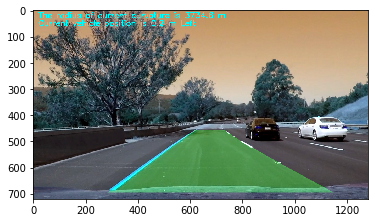

In [143]:
image = cv2.imread(('./test_images/test6.jpg'))
image = detect_lane(image)
cv2.imwrite('./output_images/detect.jpg',image)
plt.imshow(image)

In [132]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [138]:
test_output = './output_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(detect_lane) #NOTE: this function expects color images!!
%time white_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video ./output_video.mp4
[MoviePy] Writing video ./output_video.mp4







  0%|          | 0/1261 [00:00<?, ?it/s]




  0%|          | 1/1261 [00:00<04:41,  4.47it/s]




  0%|          | 2/1261 [00:00<04:53,  4.30it/s]




  0%|          | 3/1261 [00:00<04:53,  4.28it/s]




  0%|          | 4/1261 [00:00<04:55,  4.26it/s]




  0%|          | 5/1261 [00:01<04:53,  4.28it/s]




  0%|          | 6/1261 [00:01<04:50,  4.32it/s]




  1%|          | 7/1261 [00:01<04:45,  4.39it/s]




  1%|          | 8/1261 [00:01<04:43,  4.43it/s]




  1%|          | 9/1261 [00:02<04:40,  4.47it/s]




  1%|          | 10/1261 [00:02<04:43,  4.42it/s]




  1%|          | 11/1261 [00:02<04:42,  4.43it/s]




  1%|          | 12/1261 [00:02<04:39,  4.47it/s]




  1%|          | 13/1261 [00:02<04:39,  4.47it/s]




  1%|          | 14/1261 [00:03<04:39,  4.46it/s]




  1%|          | 15/1261 [00:03<04:38,  4.48it/s]




  1%|▏         | 16/1261 [00:03<04:37,  4.48it/s]




  1%|▏         | 17/1261 [00:03<04:36,  4.49it/s]




  1%|▏         | 18/1261 [00:03<04:35,  4

 19%|█▊        | 235/1261 [00:54<03:56,  4.33it/s]




 19%|█▊        | 236/1261 [00:54<03:56,  4.33it/s]




 19%|█▉        | 237/1261 [00:54<03:56,  4.33it/s]




 19%|█▉        | 238/1261 [00:54<03:56,  4.33it/s]




 19%|█▉        | 239/1261 [00:55<03:56,  4.33it/s]




 19%|█▉        | 240/1261 [00:55<03:55,  4.33it/s]




 19%|█▉        | 241/1261 [00:55<03:55,  4.33it/s]




 19%|█▉        | 242/1261 [00:55<03:55,  4.33it/s]




 19%|█▉        | 243/1261 [00:56<03:55,  4.33it/s]




 19%|█▉        | 244/1261 [00:56<03:55,  4.33it/s]




 19%|█▉        | 245/1261 [00:56<03:54,  4.33it/s]




 20%|█▉        | 246/1261 [00:56<03:54,  4.33it/s]




 20%|█▉        | 247/1261 [00:57<03:54,  4.33it/s]




 20%|█▉        | 248/1261 [00:57<03:54,  4.33it/s]




 20%|█▉        | 249/1261 [00:57<03:53,  4.33it/s]




 20%|█▉        | 250/1261 [00:57<03:53,  4.33it/s]




 20%|█▉        | 251/1261 [00:58<03:53,  4.33it/s]




 20%|█▉        | 252/1261 [00:58<03:53,  4.33it/s]




 20%|██   

 37%|███▋      | 469/1261 [01:52<03:10,  4.15it/s]




 37%|███▋      | 470/1261 [01:53<03:10,  4.15it/s]




 37%|███▋      | 471/1261 [01:53<03:10,  4.15it/s]




 37%|███▋      | 472/1261 [01:53<03:10,  4.15it/s]




 38%|███▊      | 473/1261 [01:54<03:10,  4.14it/s]




 38%|███▊      | 474/1261 [01:54<03:10,  4.14it/s]




 38%|███▊      | 475/1261 [01:54<03:09,  4.14it/s]




 38%|███▊      | 476/1261 [01:55<03:09,  4.14it/s]




 38%|███▊      | 477/1261 [01:55<03:09,  4.13it/s]




 38%|███▊      | 478/1261 [01:55<03:09,  4.13it/s]




 38%|███▊      | 479/1261 [01:55<03:09,  4.13it/s]




 38%|███▊      | 480/1261 [01:56<03:09,  4.13it/s]




 38%|███▊      | 481/1261 [01:56<03:08,  4.13it/s]




 38%|███▊      | 482/1261 [01:56<03:08,  4.13it/s]




 38%|███▊      | 483/1261 [01:57<03:08,  4.13it/s]




 38%|███▊      | 484/1261 [01:57<03:08,  4.13it/s]




 38%|███▊      | 485/1261 [01:57<03:08,  4.13it/s]




 39%|███▊      | 486/1261 [01:57<03:07,  4.12it/s]




 39%|███▊ 

 56%|█████▌    | 703/1261 [02:54<02:18,  4.02it/s]




 56%|█████▌    | 704/1261 [02:55<02:18,  4.02it/s]




 56%|█████▌    | 705/1261 [02:55<02:18,  4.02it/s]




 56%|█████▌    | 706/1261 [02:55<02:18,  4.02it/s]




 56%|█████▌    | 707/1261 [02:55<02:17,  4.02it/s]




 56%|█████▌    | 708/1261 [02:56<02:17,  4.02it/s]




 56%|█████▌    | 709/1261 [02:56<02:17,  4.02it/s]




 56%|█████▋    | 710/1261 [02:56<02:17,  4.02it/s]




 56%|█████▋    | 711/1261 [02:56<02:16,  4.02it/s]




 56%|█████▋    | 712/1261 [02:57<02:16,  4.02it/s]




 57%|█████▋    | 713/1261 [02:57<02:16,  4.02it/s]




 57%|█████▋    | 714/1261 [02:57<02:15,  4.02it/s]




 57%|█████▋    | 715/1261 [02:57<02:15,  4.02it/s]




 57%|█████▋    | 716/1261 [02:57<02:15,  4.02it/s]




 57%|█████▋    | 717/1261 [02:58<02:15,  4.02it/s]




 57%|█████▋    | 718/1261 [02:58<02:14,  4.02it/s]




 57%|█████▋    | 719/1261 [02:58<02:14,  4.02it/s]




 57%|█████▋    | 720/1261 [02:58<02:14,  4.02it/s]




 57%|█████

 74%|███████▍  | 937/1261 [03:52<01:20,  4.02it/s]




 74%|███████▍  | 938/1261 [03:53<01:20,  4.02it/s]




 74%|███████▍  | 939/1261 [03:53<01:20,  4.02it/s]




 75%|███████▍  | 940/1261 [03:53<01:19,  4.02it/s]




 75%|███████▍  | 941/1261 [03:53<01:19,  4.03it/s]




 75%|███████▍  | 942/1261 [03:54<01:19,  4.03it/s]




 75%|███████▍  | 943/1261 [03:54<01:18,  4.03it/s]




 75%|███████▍  | 944/1261 [03:54<01:18,  4.03it/s]




 75%|███████▍  | 945/1261 [03:54<01:18,  4.03it/s]




 75%|███████▌  | 946/1261 [03:54<01:18,  4.03it/s]




 75%|███████▌  | 947/1261 [03:55<01:17,  4.03it/s]




 75%|███████▌  | 948/1261 [03:55<01:17,  4.03it/s]




 75%|███████▌  | 949/1261 [03:55<01:17,  4.03it/s]




 75%|███████▌  | 950/1261 [03:55<01:17,  4.03it/s]




 75%|███████▌  | 951/1261 [03:56<01:16,  4.03it/s]




 75%|███████▌  | 952/1261 [03:56<01:16,  4.03it/s]




 76%|███████▌  | 953/1261 [03:56<01:16,  4.03it/s]




 76%|███████▌  | 954/1261 [03:56<01:16,  4.03it/s]




 76%|█████

 93%|█████████▎| 1168/1261 [04:50<00:23,  4.03it/s]




 93%|█████████▎| 1169/1261 [04:50<00:22,  4.03it/s]




 93%|█████████▎| 1170/1261 [04:50<00:22,  4.03it/s]




 93%|█████████▎| 1171/1261 [04:50<00:22,  4.03it/s]




 93%|█████████▎| 1172/1261 [04:50<00:22,  4.03it/s]




 93%|█████████▎| 1173/1261 [04:51<00:21,  4.03it/s]




 93%|█████████▎| 1174/1261 [04:51<00:21,  4.03it/s]




 93%|█████████▎| 1175/1261 [04:51<00:21,  4.03it/s]




 93%|█████████▎| 1176/1261 [04:51<00:21,  4.03it/s]




 93%|█████████▎| 1177/1261 [04:52<00:20,  4.03it/s]




 93%|█████████▎| 1178/1261 [04:52<00:20,  4.03it/s]




 93%|█████████▎| 1179/1261 [04:52<00:20,  4.03it/s]




 94%|█████████▎| 1180/1261 [04:52<00:20,  4.03it/s]




 94%|█████████▎| 1181/1261 [04:53<00:19,  4.03it/s]




 94%|█████████▎| 1182/1261 [04:53<00:19,  4.03it/s]




 94%|█████████▍| 1183/1261 [04:53<00:19,  4.03it/s]




 94%|█████████▍| 1184/1261 [04:53<00:19,  4.03it/s]




 94%|█████████▍| 1185/1261 [04:54<00:18,  4.03it

[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_video.mp4 

CPU times: user 7min 48s, sys: 1min 1s, total: 8min 50s
Wall time: 5min 14s
